🚗 Electric Vehicle Adoption in Greece vs Europe (2010–2023)
========================================

This project analyzes **electric vehicle (EV) sales** in Greece compared to the European average,
standardized by **population (per 1000 inhabitants)**.  
By normalizing sales, we can eliminate population size differences and compare adoption fairly.

## 📊 Data Sources
- **EV Sales Data**: Global EV sales by country and powertrain (BEV, PHEV, FCEV).  
- **Population Data**: World Bank dataset (`Population, total`, 1960–2023).  

## 🎯 Objectives
1. Clean and prepare the EV and population datasets.  
2. Standardize EV sales per 1000 inhabitants.  
3. Compare Greece against the European average.  
4. Extract insights about Greece’s EV adoption trajectory.
"""))


##  Load and Prepare EV Dataset

In [2]:
import pandas as pd

# Load EV dataset (replace with your actual file path)
df_ev = pd.read_csv("IEA-EV-dataEV salesHistoricalCars.csv")

# Keep only historical EV sales
df_ev = df_ev[(df_ev['category'] == 'Historical') & (df_ev['parameter'] == 'EV sales')]

# Reset index
df_ev = df_ev.reset_index(drop=True)
df_ev.head()

df_ev=df_ev.drop(['unit'],axis=1)

europe_countries = [
    'Austria','Belgium','Bulgaria','Croatia','Cyprus','Czech Republic',
    'Denmark','Estonia','Finland','France','Germany','Greece','Hungary',
    'Iceland','Ireland','Italy','Latvia','Lithuania','Luxembourg','Malta',
    'Netherlands','Norway','Poland','Portugal','Romania','Slovakia',
    'Slovenia','Spain','Sweden','Switzerland','United Kingdom'
]
df_europe=df_ev[df_ev['region'].isin(europe_countries)]
df_europe = df_europe.reset_index(drop=True)

df_greece=df_europe[(df_europe['region']=='Greece')]
df_greece=df_greece.reset_index(drop=True)


## Exploring the Greek market

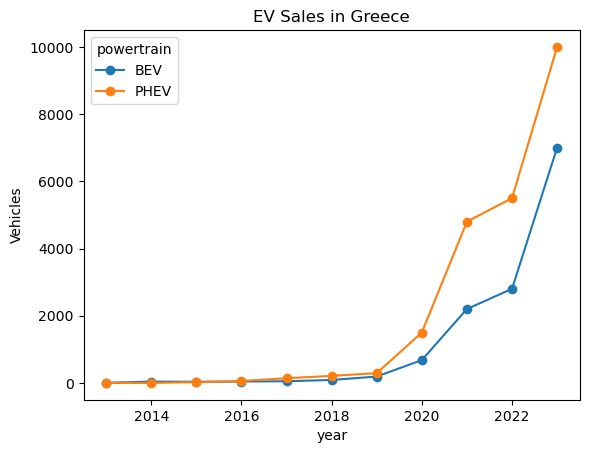

In [3]:
pivot = df_greece.pivot(index="year", columns="powertrain", values="value").fillna(0)

import matplotlib.pyplot as plt

pivot.plot(kind="line", marker="o")
plt.title("EV Sales in Greece")
plt.ylabel("Vehicles")
plt.show()

In [4]:
pivot["Total"] = pivot["BEV"] + pivot["PHEV"]
pivot["YoY_Growth_%"] = pivot["Total"].pct_change() * 100
print(pivot)


powertrain     BEV     PHEV    Total  YoY_Growth_%
year                                              
2013           3.0      0.0      3.0           NaN
2014          39.0      0.0     39.0   1200.000000
2015          35.0     22.0     57.0     46.153846
2016          41.0     56.0     97.0     70.175439
2017          50.0    140.0    190.0     95.876289
2018          88.0    210.0    298.0     56.842105
2019         190.0    290.0    480.0     61.073826
2020         680.0   1500.0   2180.0    354.166667
2021        2200.0   4800.0   7000.0    221.100917
2022        2800.0   5500.0   8300.0     18.571429
2023        7000.0  10000.0  17000.0    104.819277


##  Load and Prepare Population Dataset

In [5]:
# Load World Bank population dataset (replace with your file path)
df_pop = pd.read_csv("API_SP.POP.TOTL_DS2_en_csv_v2_590217.csv", skiprows=4)

# Keep only useful columns (Country Name + 2010-2023)
years = [str(y) for y in range(2010, 2024)]
df_pop = df_pop[['Country Name'] + years]

# Melt to long format
df_pop = df_pop.melt(id_vars=['Country Name'], var_name='year', value_name='Population')
df_pop['year'] = df_pop['year'].astype(int)

df_pop.head()

,Country Name,year,Population
0,Aruba,2010,101838.0
1,Africa Eastern and Southern,2010,530308387.0
2,Afghanistan,2010,28284089.0
3,Africa Western and Central,2010,364358270.0
4,Angola,2010,23294825.0


## Merge EV Sales with Population Data

In [6]:
# Merge datasets
df_merged = pd.merge(df_europe, df_pop, left_on=['region','year'], right_on=['Country Name','year'], how='inner')

# Drop duplicate 'Country Name' column
df_merged = df_merged.drop(columns=['Country Name'])

df_merged.head()

,region,category,parameter,mode,powertrain,year,value,Population
0,Austria,Historical,EV sales,Cars,BEV,2013,650.0,8479823.0
1,Austria,Historical,EV sales,Cars,BEV,2014,1700.0,8546356.0
2,Austria,Historical,EV sales,Cars,FCEV,2014,6.0,8546356.0
3,Austria,Historical,EV sales,Cars,FCEV,2015,4.0,8642699.0
4,Austria,Historical,EV sales,Cars,PHEV,2015,1100.0,8642699.0


## Standardize EV Sales per 1000 Inhabitants

In [7]:

# EVs per 1000 people
df_merged['EVs_per_1000'] = (df_merged['value'] / df_merged['Population']) * 1000

# Compute Europe-wide average
df_europe_avg = df_merged.groupby(['year','powertrain'])['EVs_per_1000'].mean().reset_index()
df_europe_avg.rename(columns={'EVs_per_1000': 'EVs_per_1000_avg'}, inplace=True)

# Merge back
df_compare = pd.merge(df_merged, df_europe_avg, on=['year','powertrain'], how='left')
df_compare = df_compare[df_compare["powertrain"] != "FCEV"]
df_compare.head()


,region,category,parameter,mode,powertrain,year,value,Population,EVs_per_1000,EVs_per_1000_avg
0,Austria,Historical,EV sales,Cars,BEV,2013,650.0,8479823.0,0.076653,0.156284
1,Austria,Historical,EV sales,Cars,BEV,2014,1700.0,8546356.0,0.198915,0.364892
4,Austria,Historical,EV sales,Cars,PHEV,2015,1100.0,8642699.0,0.127275,0.316582
5,Austria,Historical,EV sales,Cars,BEV,2015,1700.0,8642699.0,0.196698,0.378071
6,Austria,Historical,EV sales,Cars,BEV,2016,3800.0,8736668.0,0.434948,0.341566


## Greece vs Europe: EV Adoption Trends

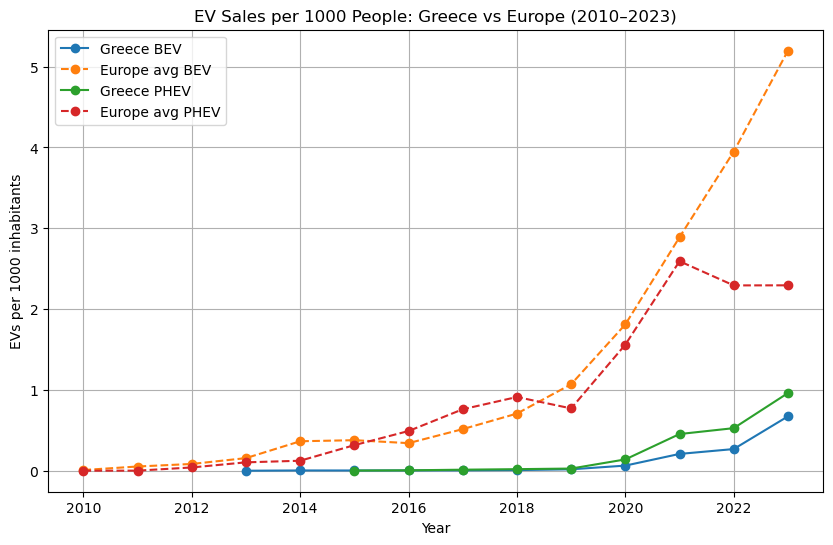

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for pt in df_compare['powertrain'].unique():
    df_greece = df_compare[df_compare['region'] == 'Greece']
    df_greece_pt = df_greece[df_greece['powertrain'] == pt]
    df_avg_pt = df_europe_avg[df_europe_avg['powertrain'] == pt]
    
    plt.plot(df_greece_pt['year'], df_greece_pt['EVs_per_1000'], marker='o', label=f'Greece {pt}')
    plt.plot(df_avg_pt['year'], df_avg_pt['EVs_per_1000_avg'], marker='o', linestyle='--', label=f'Europe avg {pt}')

plt.title("EV Sales per 1000 People: Greece vs Europe (2010–2023)")
plt.xlabel("Year")
plt.ylabel("EVs per 1000 inhabitants")
plt.legend()
plt.grid(True)
plt.show()


## Insights & Conclusion

- **Early Years (2013–2018)**: Greece had very few EV sales per capita, far below the European average.  
- **Acceleration (2019–2021)**: Adoption increased sharply after 2019, especially for PHEVs, likely due to incentives and market availability.  
- **Catching Up (2022–2023)**: Greece still lags Europe in BEVs per capita, but growth rates suggest narrowing gap.  
- **Key takeaway**: While Greece started late, momentum post-2020 indicates strong growth potential in EV adoption.